In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the Shakespeare dataset without as_supervised=True
dataset, info = tfds.load('tiny_shakespeare', split='train', with_info=True)

# Convert the dataset to a list of strings for easier manipulation
text = ''
for item in dataset:
    text += item['text'].numpy().decode('utf-8')

# Display the first 500 characters of the text
print(text[:500])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [11]:
import numpy as np
# Create a character vocabulary
vocab = sorted(set(text))
char2idx = {u: i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

# Convert text to integer representation
text_as_int = np.array([char2idx[c] for c in text])

# Set the maximum length for sequences
seq_length = 100
examples_per_epoch = len(text) // seq_length

# Create training examples and targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# Batch the sequences
sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

# Split the sequences into input and output
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

# Display an example input and target sequence
for input_example, target_example in dataset.take(1):
    print('Input:', repr(''.join([idx2char[i] for i in input_example.numpy()])))
    print('Target:', repr(''.join([idx2char[i] for i in target_example.numpy()])))


Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


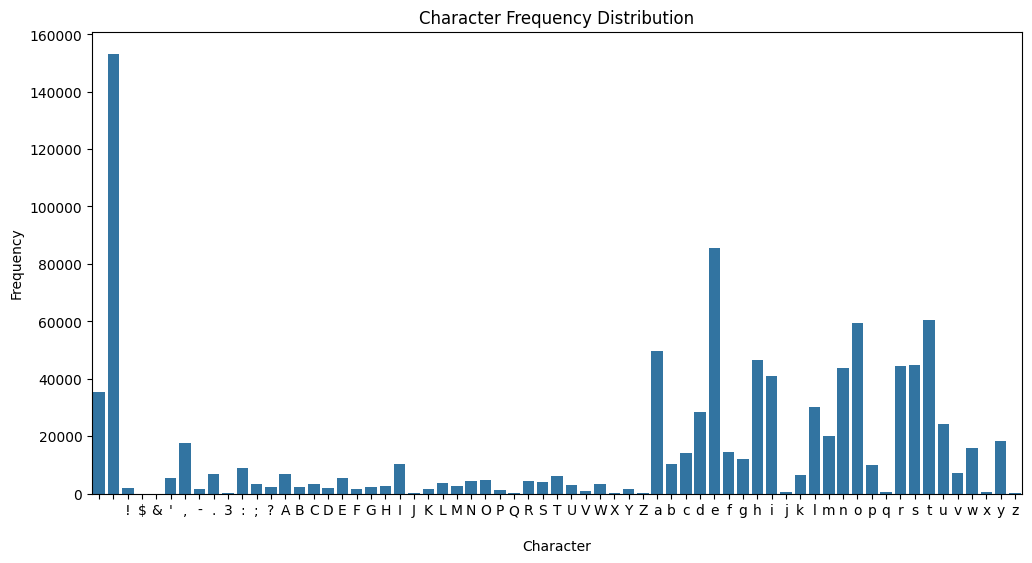

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate character frequencies
char_freq = {char: text.count(char) for char in vocab}

# Plot character frequencies
plt.figure(figsize=(12, 6))
sns.barplot(x=list(char_freq.keys()), y=list(char_freq.values()))
plt.title('Character Frequency Distribution')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.show()


In [13]:
# Build the RNN model
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(None,)),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
])

model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 256)           │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 1024)          │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 65)            │          66,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,330,241 (20.33 MB)

 Trainable params: 5,330,241 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - loss: 2.9201
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 1.8721
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 1.5972
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 1.4632
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - loss: 1.3751
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 1.3154
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - loss: 1.2702
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - loss: 1.2241
Epoch 9/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 1.1801
Epoch 10/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 1.1391


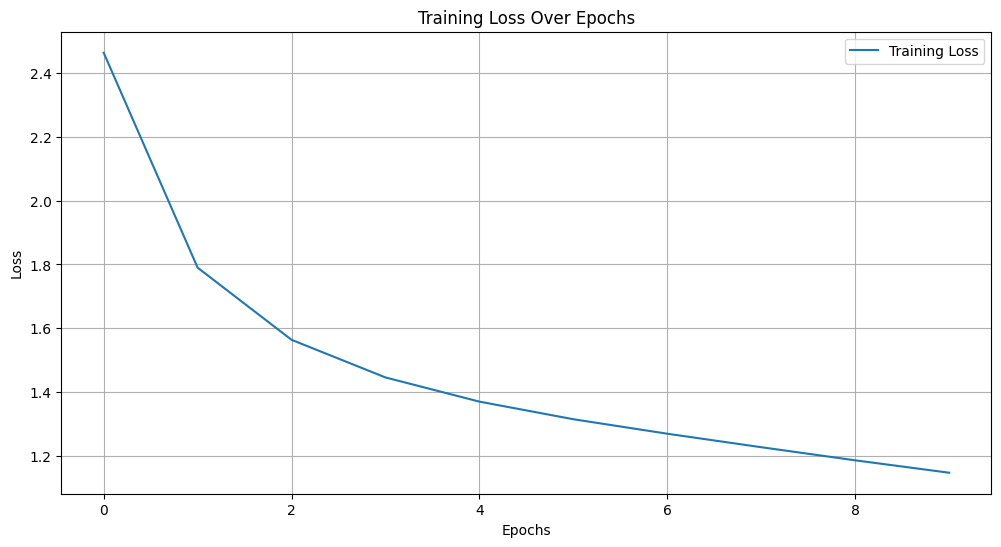

In [14]:
# Define training parameters
BATCH_SIZE = 64
BUFFER_SIZE = 10000
EPOCHS = 10

# Prepare the data for training
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Train the model
history = model.fit(dataset, epochs=EPOCHS)

# Plot the training loss over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
def generate_text(model, start_string, num_generate=1000):
    # Convert start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store the results
    text_generated = []

    # Temperature parameter: controls the randomness of predictions
    temperature = 1.0

    # Initialize the hidden state (no need to reset manually)
    model.reset_states = lambda: None  # No-op for non-stateful models

    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return start_string + ''.join(text_generated)

# Generate text
print(generate_text(model, start_string="ROMEO: "))


ROMEO: IORWhy, y.

T:
Y brsitomnon:
p t, nod han piturouth t w'd. PFwhtouthe NORENourn ngrchyonth surd s angh mbe may of trs ache,
GK
Ad h,
Hee!'sy slayolour
WARKe ofr'solldd s,
Ma vesse pon crcomosouretofokng yous alan.
As WALY Moo Mage, be
ASILArishevis.
Ny TI a t se JD:
Ad d de nat
Bhive IOLESTharoupe,




Taia r:
Cr wO.
ARINd he y, so my isend nin id
IU:
D.
Quthowan mpu s depind JVOMingusinivemouty blink ut fo is h ave. mand hers hiepe ng ftivoordery CF t sin tstwerourerer,
Wat



D
PAl san,-har y IVor upest mond sis LAThay st, aryo bulime s youthad am:
I ANESt, ETinglew, hase
Hhe'

S. MA? boundapon, irithie f timiofaraHChelonas f my mind f mo tak ser mathave.
Bar th d-wnif o bucOrvito hang s athak whotharareverit thus I ceth wenghis my thisitheceomers
RKESGUII tiscyson.

SCo.
ireauzes

S: w pes whed ty, t w!
COQY thand wn s, th I d. is p;'st hiThe gowagan henoupos, ton w bele f hay whe a vale ciladmoulay n JHenomanck.
AMI icer?
MNENG$, tin aryordecocacour choreak:

I wONTh Mire m 